In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Data Preprocessing

In [2]:
path_to_data = Path('../data')
# Import only a fraction of data for efficient testing
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None, nrows=1000)
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

feature_columns = cards + forehand

data.columns = cards + forehand + user + trump



### Remve entries with user == 0

In [3]:
data[data['user'] == 0].count()

DA       283
DK       283
DQ       283
DJ       283
D10      283
D9       283
D8       283
D7       283
D6       283
HA       283
HK       283
HQ       283
HJ       283
H10      283
H9       283
H8       283
H7       283
H6       283
SA       283
SK       283
SQ       283
SJ       283
S10      283
S9       283
S8       283
S7       283
S6       283
CA       283
CK       283
CQ       283
CJ       283
C10      283
C9       283
C8       283
C7       283
C6       283
FH       283
user     283
trump    283
dtype: int64

In [4]:
data.drop(data[data['user'] == 0].index, inplace=True)

### Load User Stats

In [5]:
player_stats = pd.read_json(path_to_data / 'stat' / 'player_all_stat.json')
player_stats.head()

,id,mean,std,nr
0,0,78.433100,42.186764,1978858
1,6955,76.191936,41.780344,4241
2,54404,78.010880,41.985297,7445
3,74994,76.775460,41.428476,7669
4,56143,76.774029,41.546253,978


In [6]:
print(f"Mean Max: {player_stats['mean'].max()}")
print(f"Mean Min: {player_stats['mean'].min()}")
print(f"Mean Avg: {player_stats['mean'].mean()}")

print(f"STd Max: {player_stats['std'].max()}")
print(f"STd Min: {player_stats['std'].min()}")
print(f"STd Avg: {player_stats['std'].mean()}")

Mean Max: 140.0
Mean Min: 0.0
Mean Avg: 77.42586010810032
STd Max: 92.63098833543772
STd Min: 0.0
STd Avg: 42.10781643599714


<Axes: >

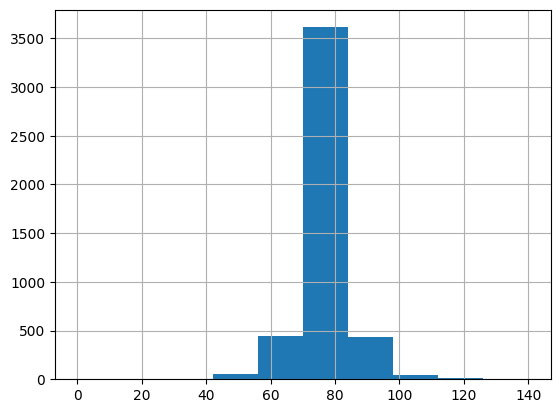

In [7]:
player_stats['mean'].hist()

### Add mean to trump dataset

In [8]:
data = data.merge(player_stats, left_on='user', right_on='id', how='left')

# Drop the columns from player_stats that are not needed
data.drop(columns=['id'], inplace=True)
data.drop(columns=['std'], inplace=True)
data.drop(columns=['nr'], inplace=True)

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CJ,C10,C9,C8,C7,C6,FH,user,trump,mean
0,0,0,0,1,1,0,1,1,0,0,...,0,0,0,1,0,0,0,53248,6,80.209033
1,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,4613,5,79.254714
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,68780,6,78.182220
3,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,24555,5,72.863905
4,0,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,1,8392,4,80.793806


### Delete entries from bad users

In [9]:
data = data[data['mean'] > player_stats['mean'].mean()]

### Drop non feature or target variables

In [10]:
data.drop('user', axis='columns', inplace=True)
data.drop('mean', axis='columns', inplace=True)

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,6
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,5
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,6
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,4
5,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,5


## Target Variable 'Trump'

### One-Hot-Encode

In [11]:
data.trump = data.trump.astype('category')
data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS',
                                  4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,PUSH
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,UNE_UFE
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,PUSH
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,OBE_ABE
5,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,UNE_UFE


In [12]:
data = pd.get_dummies(data, ['trump', ])
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,C7,C6,FH,trump_DIAMONDS,trump_HEARTS,trump_SPADES,trump_CLUBS,trump_OBE_ABE,trump_UNE_UFE,trump_PUSH
0,0,0,0,1,1,0,1,1,0,0,...,0,0,0,False,False,False,False,False,False,True
1,0,0,0,0,0,0,0,0,1,1,...,1,0,0,False,False,False,False,False,True,False
2,1,0,0,1,0,0,0,0,0,0,...,1,1,0,False,False,False,False,False,False,True
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,False,False,False,False,True,False,False
5,0,0,1,0,0,0,1,0,1,0,...,0,0,1,False,False,False,False,False,True,False


In [13]:
data.columns

Index(['DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6', 'HA', 'HK', 'HQ',
       'HJ', 'H10', 'H9', 'H8', 'H7', 'H6', 'SA', 'SK', 'SQ', 'SJ', 'S10',
       'S9', 'S8', 'S7', 'S6', 'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7',
       'C6', 'FH', 'trump_DIAMONDS', 'trump_HEARTS', 'trump_SPADES',
       'trump_CLUBS', 'trump_OBE_ABE', 'trump_UNE_UFE', 'trump_PUSH'],
      dtype='object')

## Model

In [14]:
# Split into features (X) and target (y)
X = data[feature_columns]
y = data[
    [
        "trump_DIAMONDS",
        "trump_HEARTS",
        "trump_SPADES",
        "trump_CLUBS",
        "trump_OBE_ABE",
        "trump_UNE_UFE",
        "trump_PUSH",
    ]
]

### Normalization

The normalization is not really necessary, because everything in the dataset is one-hot-encoded

In [15]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test sets
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.transform(X_test)

In [44]:
model = keras.Sequential()

model.add(keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/Users/timon/.pyenv/versions/3.10.16/envs/dl4g/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9286 - loss: 0.2610 - val_accuracy: 0.4505 - val_loss: 1.9185
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9620 - loss: 0.2436 - val_accuracy: 0.4505 - val_loss: 1.9333
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9421 - loss: 0.2428 - val_accuracy: 0.4615 - val_loss: 1.9304
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9532 - loss: 0.2389 - val_accuracy: 0.4505 - val_loss: 1.9424
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9498 - loss: 0.2459 - val_accuracy: 0.4615 - val_loss: 1.9446
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9438 - loss: 0.2357 - val_accuracy: 0.4615 - val_loss: 1.9448
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9573 - loss: 0.2239 - val_accuracy: 0.4725 - val_loss: 1.9423
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9764 - loss: 0.2108 - val_accuracy: 0.4615 - val_loss:

In [55]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4912 - loss: 1.9980
Test Loss: 2.0644328594207764, Test Accuracy: 0.47787609696388245


In [ ]:
# Predict on new data
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)  # Convert softmax output to class label

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
